# Coding Requirements

1. Choose a dataset that has an outcome (predictive) variable.
2. Split that into train and test.
3. Define a metric to evaluate a machine learning model.
4. Build a pipeline using Airflow or MLflow or your platform pipeline to train a machine learning model using the train dataset (use AutoML to refine the category of algorithms).
5. Deploy the model for inference.
6. Set up model monitoring (if there is a monitoring dashboard show that).
7. Use the test data with the deployed model and validate the results (metric) and model monitoring.
8. Change atleast 2 feature values of the test dataset (you can put in random values or swap 2 features).
9. Use the "changed" test data with the deployed model and validate the results (metric) and verify observation with model monitoring.

# Presentation Requirements

Presentation in class that covers the above points with a video demo of #7 and #9.
The presentation PPT should include

1. EDA of your chosen dataset
2. Metric to evaluate the machine learning model
3. Pipeline you used to train the machine learning model
4. AutoML results and the chosen algorithm
5. Model monitoring
6. The "change" in the test dataset
7. Github link that contains the project code

Clearly outline which member did which part of the project.

Data Available at: https://www.kaggle.com/datasets/muhammadroshaanriaz/time-wasters-on-social-media/data

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
import kagglehub
import shutil
import os
import glob
import pandas as pd
from pprint import pprint as pp
import numpy as np

# Downloading the data from kaggle
path = kagglehub.dataset_download("muhammadroshaanriaz/time-wasters-on-social-media")

os.makedirs('./data', exist_ok=True)
if os.path.isdir(path):
    files = glob.glob(os.path.join(path, '**'), recursive=True)
    for file in files:
        if os.path.isfile(file): 
            shutil.move(file, './data')
else:
    shutil.move(path, './data')
print("Path to dataset files:", './data')

df = pd.read_csv('./data/Time-Wasters on Social Media.csv')
print(f"Dataframe columns: {df.columns}")
df.drop('UserID', axis  = 1, inplace = True)
df.head()

Path to dataset files: ./data
Dataframe columns: Index(['UserID', 'Age', 'Gender', 'Location', 'Income', 'Debt',
       'Owns Property', 'Profession', 'Demographics', 'Platform',
       'Total Time Spent', 'Number of Sessions', 'Video ID', 'Video Category',
       'Video Length', 'Engagement', 'Importance Score', 'Time Spent On Video',
       'Number of Videos Watched', 'Scroll Rate', 'Frequency',
       'ProductivityLoss', 'Satisfaction', 'Watch Reason', 'DeviceType', 'OS',
       'Watch Time', 'Self Control', 'Addiction Level', 'CurrentActivity',
       'ConnectionType'],
      dtype='object')


,Age,Gender,Location,Income,Debt,Owns Property,Profession,Demographics,Platform,Total Time Spent,...,ProductivityLoss,Satisfaction,Watch Reason,DeviceType,OS,Watch Time,Self Control,Addiction Level,CurrentActivity,ConnectionType
0,56,Male,Pakistan,82812,True,True,Engineer,Rural,Instagram,80,...,3,7,Procrastination,Smartphone,Android,9:00 PM,5,5,Commuting,Mobile Data
1,46,Female,Mexico,27999,False,True,Artist,Urban,Instagram,228,...,5,5,Habit,Computer,Android,5:00 PM,7,3,At school,Wi-Fi
2,32,Female,United States,42436,False,True,Engineer,Rural,Facebook,30,...,6,4,Entertainment,Tablet,Android,2:00 PM,8,2,At home,Mobile Data
3,60,Male,Barzil,62963,True,False,Waiting staff,Rural,YouTube,101,...,3,7,Habit,Smartphone,Android,9:00 PM,5,5,Commuting,Mobile Data
4,25,Male,Pakistan,22096,False,True,Manager,Urban,TikTok,136,...,8,2,Boredom,Smartphone,iOS,8:00 AM,10,0,At home,Mobile Data


# EDA

<Axes: >

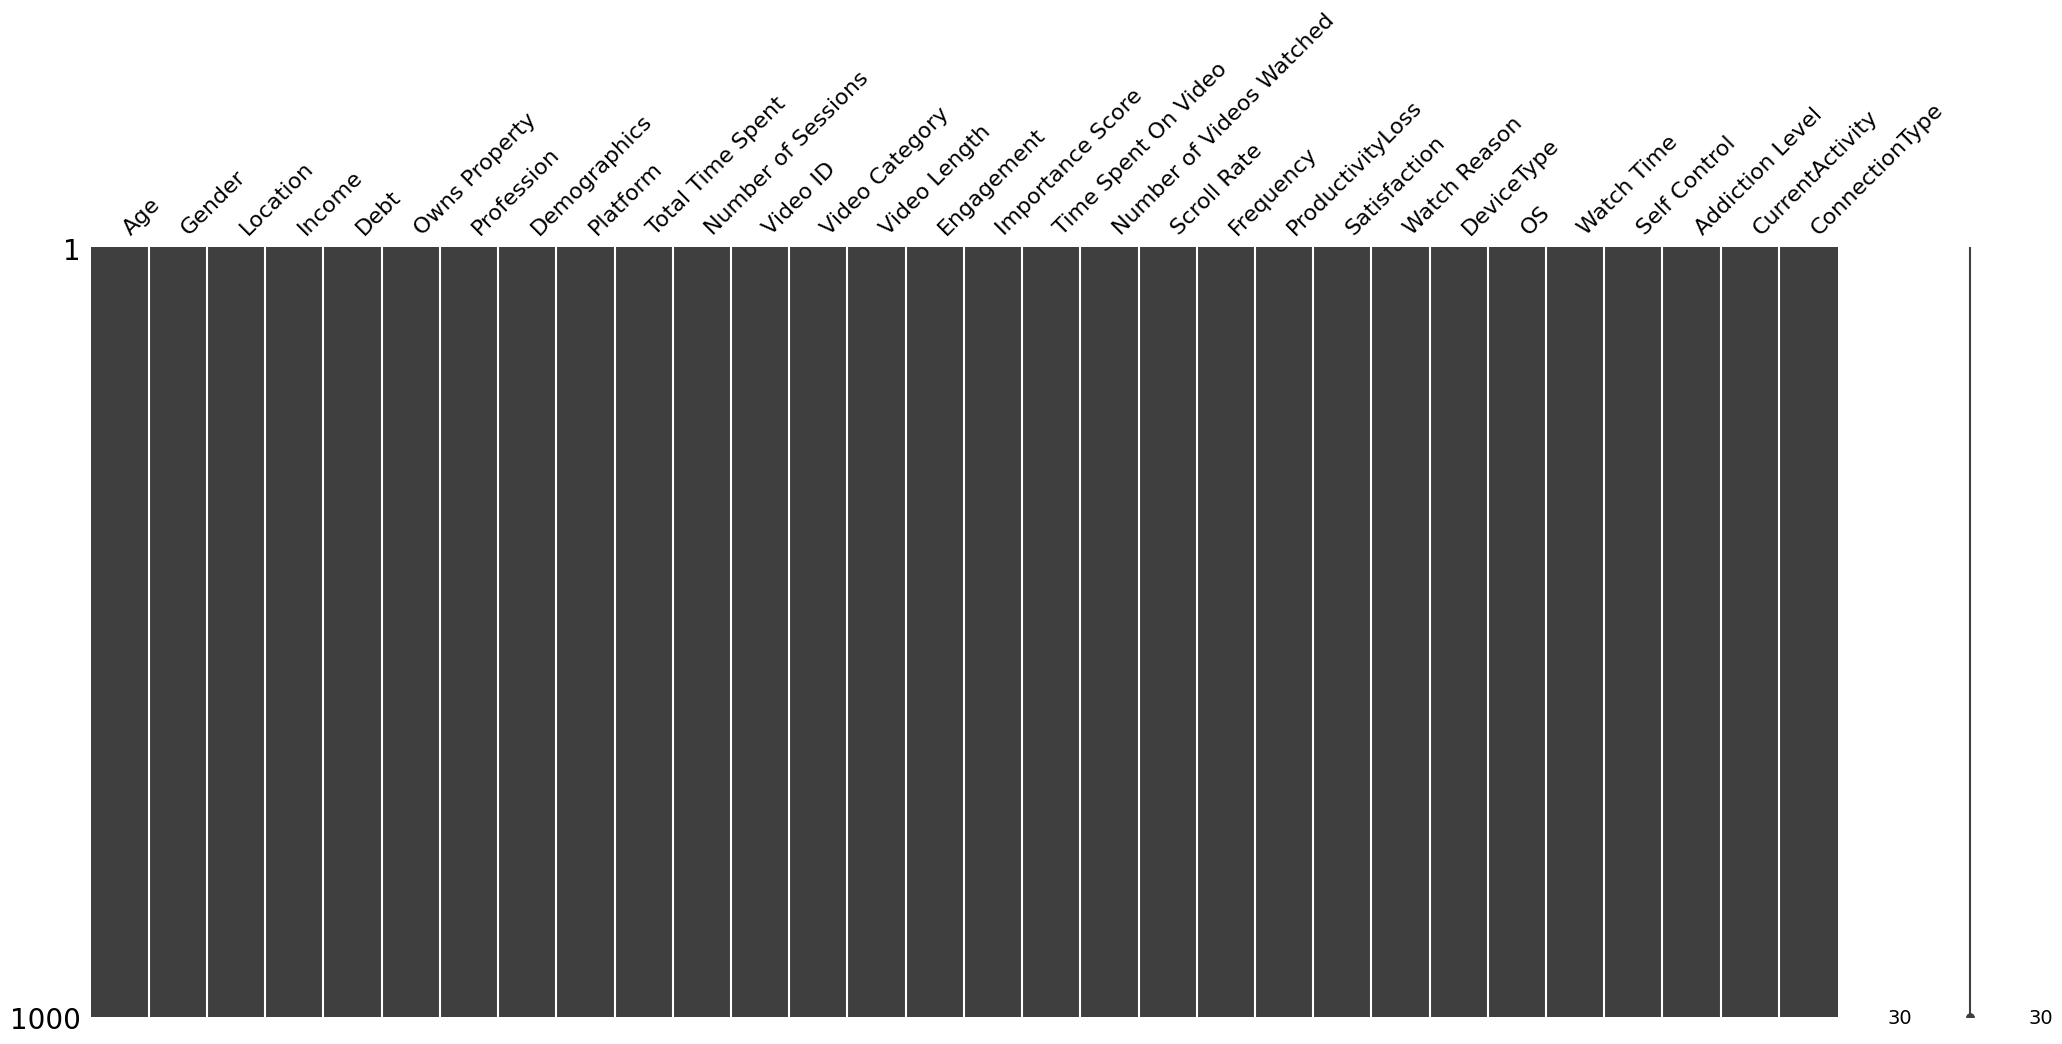

In [52]:
import missingno as msno

# Visualize the missing values in the dataframe
msno.matrix(df)

# Preprocessing

In [58]:
def good_one_hot(X, n_unique):

    X_copy = X.copy()  
    
    for col in X_copy.select_dtypes(include=['object', 'category']).columns:
        top_categories = X_copy[col].value_counts().nlargest(n_unique).index
        X_copy[col] = X_copy[col].where(X_copy[col].isin(top_categories), other="Other")
    
    X_encoded = pd.get_dummies(X_copy, columns=X_copy.select_dtypes(include=['object', 'category']).columns)
    
    return X_encoded

def add_interaction_terms(X):
    from itertools import combinations
    interaction_terms = pd.DataFrame(index=X.index)
    continuous_columns = X.select_dtypes(include=[np.number]).columns
    for col1, col2 in combinations(continuous_columns, 2):
        interaction_term_name = f"{col1}_x_{col2}"
        interaction_terms[interaction_term_name] = X[col1] * X[col2]
    return pd.concat([X, interaction_terms], axis=1)

df = good_one_hot(df, 100)

y = df['ProductivityLoss']
y = pd.DataFrame({"Brain Rot": y})
y['Brain Rot'] = y['Brain Rot'].apply(lambda x: 0 if x < 5 else 1)
# x = df.drop(columns=['ProductivityLoss', 'Satisfaction', 'Addiction Level', 'Self Control'])
x = df.drop(columns=['ProductivityLoss', 'Satisfaction', 'Addiction Level', 'Self Control'])
x = add_interaction_terms(x)

features = x.copy()
target = y.copy()

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Add these to the data folder for the AutoML portion
train = pd.concat([x_train, y_train], axis=1)
test = pd.concat([x_test, y_test], axis=1)
train.to_csv('./data/train.csv', index=False)
test.to_csv('./data/test.csv', index=False)

# AutoML

Using AutoML to define what are some good model categories to try out

In [59]:
import h2o
from h2o.automl import H2OAutoML

h2o.init(port = 54325, nthreads = -1, max_mem_size = "6g")
train = h2o.import_file("data/train.csv")
test = h2o.import_file("data/test.csv")
x = train.columns
y = "Brain Rot"
if y in x:
    x.remove(y)
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
aml = H2OAutoML(max_models=100, max_runtime_secs=60, seed=1) 
aml.train(x=x, y=y, training_frame=train)
lb = aml.leaderboard
lb.head(rows=lb.nrows)

Checking whether there is an H2O instance running at http://localhost:54325. connected.


H2O_cluster_uptime:,14 hours 47 mins
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,23 days
H2O_cluster_name:,H2O_from_python_zfara_e6df1c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.814 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
15:07:16.932: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_11_20241125_150716_model_7,0.885002,0.370097,0.921678,0.139316,0.33215,0.110324
GBM_4_AutoML_11_20241125_150716,0.883429,0.380401,0.921623,0.144942,0.338009,0.11425
GBM_grid_1_AutoML_11_20241125_150716_model_3,0.883237,0.382684,0.920805,0.153186,0.34104,0.116309
GBM_grid_1_AutoML_11_20241125_150716_model_2,0.881441,0.37251,0.910989,0.143995,0.333602,0.111291
GBM_5_AutoML_11_20241125_150716,0.880985,0.379166,0.912093,0.151181,0.335651,0.112662
GBM_grid_1_AutoML_11_20241125_150716_model_1,0.880884,0.391266,0.920705,0.166778,0.345452,0.119337
GBM_2_AutoML_11_20241125_150716,0.878753,0.38229,0.916638,0.141154,0.338524,0.114599
GBM_grid_1_AutoML_11_20241125_150716_model_5,0.877329,0.380886,0.916548,0.142101,0.337018,0.113581
GBM_3_AutoML_11_20241125_150716,0.876908,0.386688,0.91774,0.148451,0.341663,0.116733
GLM_1_AutoML_11_20241125_150716,0.875599,0.396389,0.90708,0.166778,0.346113,0.119794


In [60]:
# Display the top 5 models from the H2O AutoML leaderboard
lb.head(rows=25)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_11_20241125_150716_model_7,0.885002,0.370097,0.921678,0.139316,0.33215,0.110324
GBM_4_AutoML_11_20241125_150716,0.883429,0.380401,0.921623,0.144942,0.338009,0.11425
GBM_grid_1_AutoML_11_20241125_150716_model_3,0.883237,0.382684,0.920805,0.153186,0.34104,0.116309
GBM_grid_1_AutoML_11_20241125_150716_model_2,0.881441,0.37251,0.910989,0.143995,0.333602,0.111291
GBM_5_AutoML_11_20241125_150716,0.880985,0.379166,0.912093,0.151181,0.335651,0.112662
GBM_grid_1_AutoML_11_20241125_150716_model_1,0.880884,0.391266,0.920705,0.166778,0.345452,0.119337
GBM_2_AutoML_11_20241125_150716,0.878753,0.38229,0.916638,0.141154,0.338524,0.114599
GBM_grid_1_AutoML_11_20241125_150716_model_5,0.877329,0.380886,0.916548,0.142101,0.337018,0.113581
GBM_3_AutoML_11_20241125_150716,0.876908,0.386688,0.91774,0.148451,0.341663,0.116733
GLM_1_AutoML_11_20241125_150716,0.875599,0.396389,0.90708,0.166778,0.346113,0.119794


Now it seems the main model architectures are 
1. Gradient Boosting Trees
2. Deep Learning
3. Random Forest

# MLFlow
Now let's do the MLFlow sections

In [61]:
# Required imports
import seaborn as sns
import shap
import mlflow
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

mlflow.set_experiment("Flexible Model Experiment")

# Function to evaluate regression metrics
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return r2, rmse, mae, mse



# Flexible experiment runner
def run_experiment(features, target, model, hyperparams=None):
    # Preprocessing
    try:
        X = features
        y = target
        
        X.fillna(X.mean(), inplace=True)  # For numeric columns

        # Scale continuous features
        scaler = StandardScaler()
        continuous_columns = X.select_dtypes(include=['float64', 'int64']).columns
        X[continuous_columns] = scaler.fit_transform(X[continuous_columns])

        # Add interaction terms
        
        X = X.apply(pd.to_numeric, errors='coerce')
        y = y.apply(pd.to_numeric, errors='coerce')

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

        # Configure model
        if hyperparams:
            model.set_params(**hyperparams)

        # Train the model
        model.fit(X_train, y_train)

        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Metrics
        metrics_train = regression_metrics(y_train, y_pred_train)
        metrics_test = regression_metrics(y_test, y_pred_test)

        # Log parameters and metrics to MLflow
        mlflow.start_run()
        mlflow.log_param("model", type(model).__name__)
        if hyperparams:
            mlflow.log_params(hyperparams)
        mlflow.log_metric("r2_train", metrics_train[0])
        mlflow.log_metric("r2_test", metrics_test[0])
        mlflow.log_metric("rmse_train", metrics_train[1])
        mlflow.log_metric("rmse_test", metrics_test[1])
        mlflow.log_metric("mae_train", metrics_train[2])
        mlflow.log_metric("mae_test", metrics_test[2])
        mlflow.log_metric("mse_train", metrics_train[3])
        mlflow.log_metric("mse_test", metrics_test[3])

        # Residual plot
        sns.residplot(x=y_test, y=y_pred_test, lowess=True, line_kws={"color": "red", "lw": 1})
        plt.title("Residual Plot")
        plt.xlabel("Actual Values")
        plt.ylabel("Residuals")
        plt.show()

        # Predicted vs Actual
        plt.scatter(y_test, y_pred_test, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title("Predicted vs Actual")
        plt.show()

        # For tree-based models use the tree explainer
        if isinstance(model, (RandomForestRegressor, XGBRegressor)):
            # Tree-based models
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)
            shap.summary_plot(shap_values, X_test)
        elif isinstance(model, MLPRegressor):
            # For MLPRegressor, use KernelExplainer
            # Select a subset of the training data as background data
            background = X_train.sample(n=100, random_state=0)
            # Define a prediction function
            def model_predict(X):
                return model.predict(X)
            explainer = shap.KernelExplainer(model_predict, background)
            # Compute SHAP values (consider using a smaller nsamples value for large datasets)
            shap_values = explainer.shap_values(X_test, nsamples=100)
            shap.summary_plot(shap_values, X_test)
        else:
            # Other models
            explainer = shap.Explainer(model.predict, X_train)
            shap_values = explainer.shap_values(X_test)
            shap.summary_plot(shap_values, X_test)


    except Exception as e:

        print(f"An error occurred: {e}")
        raise e

    finally:
        mlflow.end_run()




In [62]:
# Required imports
import seaborn as sns
import shap
import mlflow
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

mlflow.set_experiment("Classification Experiment")

# Function to evaluate classification metrics
def classification_metrics(y_true, y_pred):
    
    y_pred = (y_pred > .5).astype(int)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    return accuracy, precision, recall, f1, roc_auc

# Flexible experiment runner
def run_experiment(features, target, model, hyperparams=None):
    # Preprocessing
    try:
        X = features
        y = target
        
        X.fillna(X.mean(), inplace=True)  # For numeric columns

        # Scale continuous features
        scaler = StandardScaler()
        continuous_columns = X.select_dtypes(include=['float64', 'int64']).columns
        X[continuous_columns] = scaler.fit_transform(X[continuous_columns])

        # Add interaction terms
        X = X.apply(pd.to_numeric, errors='coerce')
        # y = y.apply(pd.to_numeric, errors='coerce')

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

        # Configure model
        if hyperparams:
            model.set_params(**hyperparams)

        # Train the model
        model.fit(X_train, y_train)

        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Metrics
        metrics_train = classification_metrics(y_train, y_pred_train)
        metrics_test = classification_metrics(y_test, y_pred_test)

        # Log parameters and metrics to MLflow
        mlflow.start_run()
        mlflow.log_param("model", type(model).__name__)
        if hyperparams:
            mlflow.log_params(hyperparams)
        mlflow.log_metric("accuracy_train", metrics_train[0])
        mlflow.log_metric("accuracy_test", metrics_test[0])
        mlflow.log_metric("precision_train", metrics_train[1])
        mlflow.log_metric("precision_test", metrics_test[1])
        mlflow.log_metric("recall_train", metrics_train[2])
        mlflow.log_metric("recall_test", metrics_test[2])
        mlflow.log_metric("f1_train", metrics_train[3])
        mlflow.log_metric("f1_test", metrics_test[3])
        mlflow.log_metric("roc_auc_train", metrics_train[4])
        mlflow.log_metric("roc_auc_test", metrics_test[4])
        
        if isinstance(model, (RandomForestClassifier, XGBClassifier)):
            # Tree-based models
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)
            shap.summary_plot(shap_values, X_test)
            mlflow.log_figure(plt.gcf(), "shap_summary_plot.png")
        elif isinstance(model, MLPClassifier):
            # For MLPRegressor, use KernelExplainer
            # Select a subset of the training data as background data
            background = X_train.sample(n=100, random_state=0)
            # Define a prediction function
            def model_predict(X):
                return model.predict(X)
            explainer = shap.KernelExplainer(model_predict, background)
            # Compute SHAP values (consider using a smaller nsamples value for large datasets)
            shap_values = explainer.shap_values(X_test, nsamples=100)
            shap.summary_plot(shap_values, X_test)
            mlflow.log_figure(plt.gcf(), "shap_summary_plot.png")
        else:
            # Other models
            explainer = shap.Explainer(model.predict, X_train)
            shap_values = explainer.shap_values(X_test)
            shap.summary_plot(shap_values, X_test)
            mlflow.log_figure(plt.gcf(), "shap_summary_plot.png")
            
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred_test)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
        mlflow.log_figure(plt.gcf(), "confusion_matrix.png")
        
        y_prob = model.predict_proba(X_test)[:, 1]
        # Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        plt.figure()
        plt.plot(recall, precision, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.show()
        mlflow.log_figure(plt.gcf(), "precision_recall_curve.png")

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure()
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()
        mlflow.log_figure(plt.gcf(), "roc_curve.png")


    except Exception as e:
        print(f"An error occurred: {e}")
        raise e

    finally:
        mlflow.end_run()


Iteration 1/10
Hyperparameters: {'n_estimators': 600, 'max_depth': 12, 'learning_rate': 0.2, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.5, 'min_child_weight': 3, 'reg_alpha': 1.0, 'reg_lambda': 5.0, 'scale_pos_weight': 0.5151515151515151}


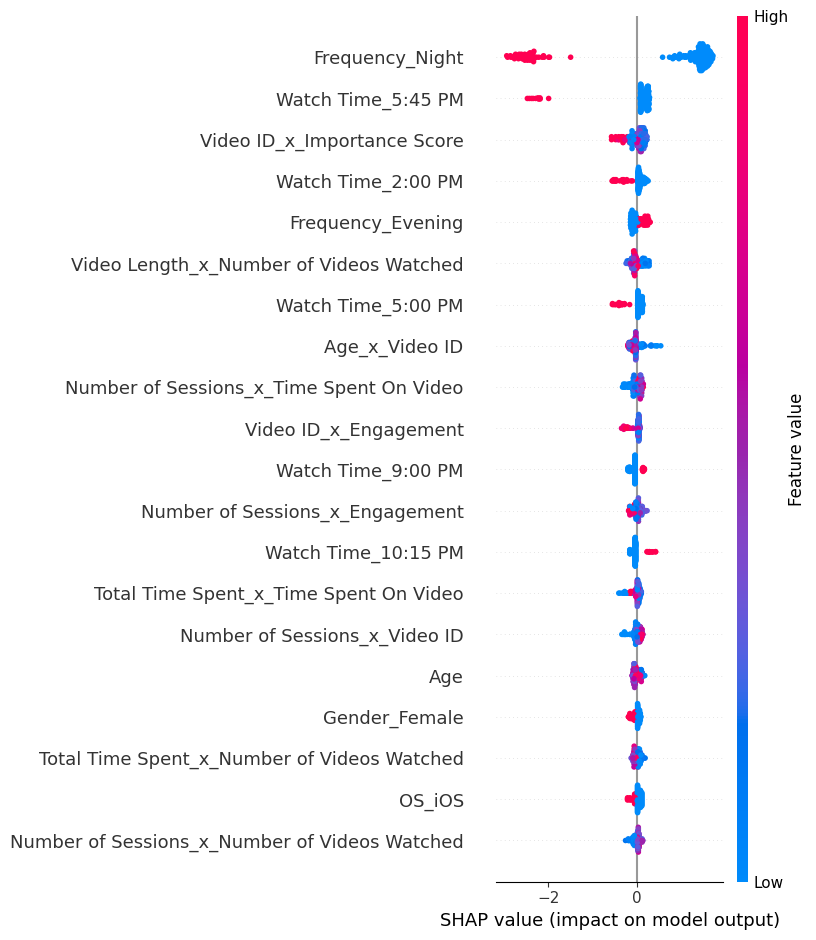

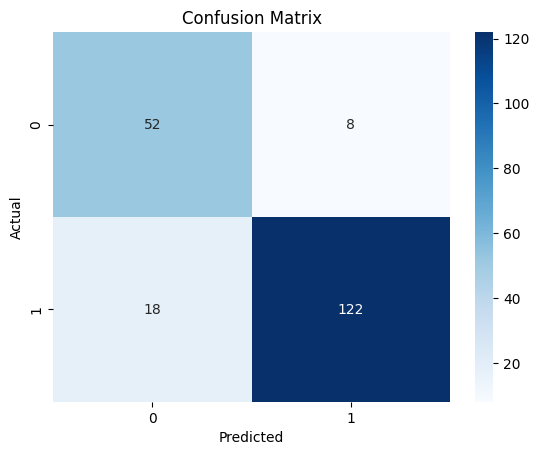

<Figure size 640x480 with 0 Axes>

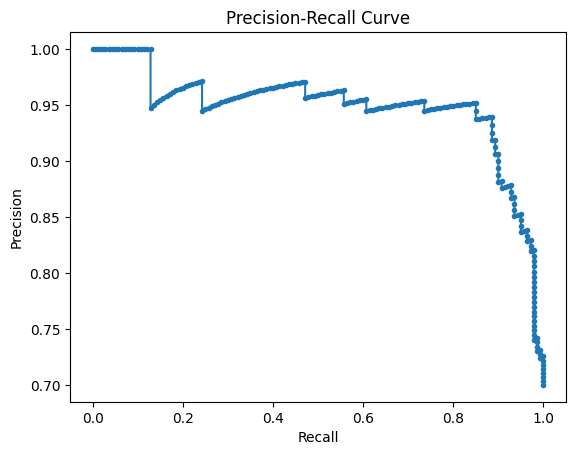

<Figure size 640x480 with 0 Axes>

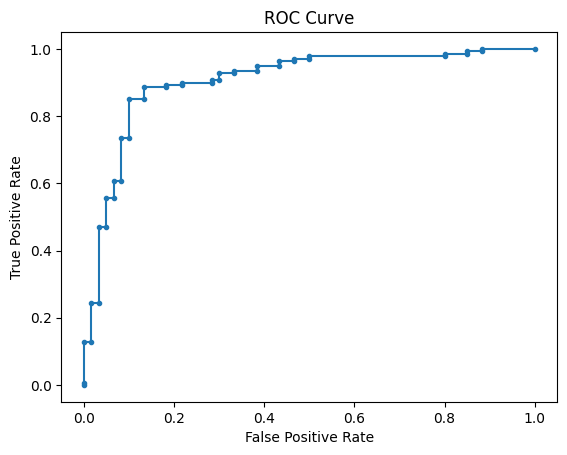

Iteration 2/10
Hyperparameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.05, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 0.3, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.5, 'scale_pos_weight': None}


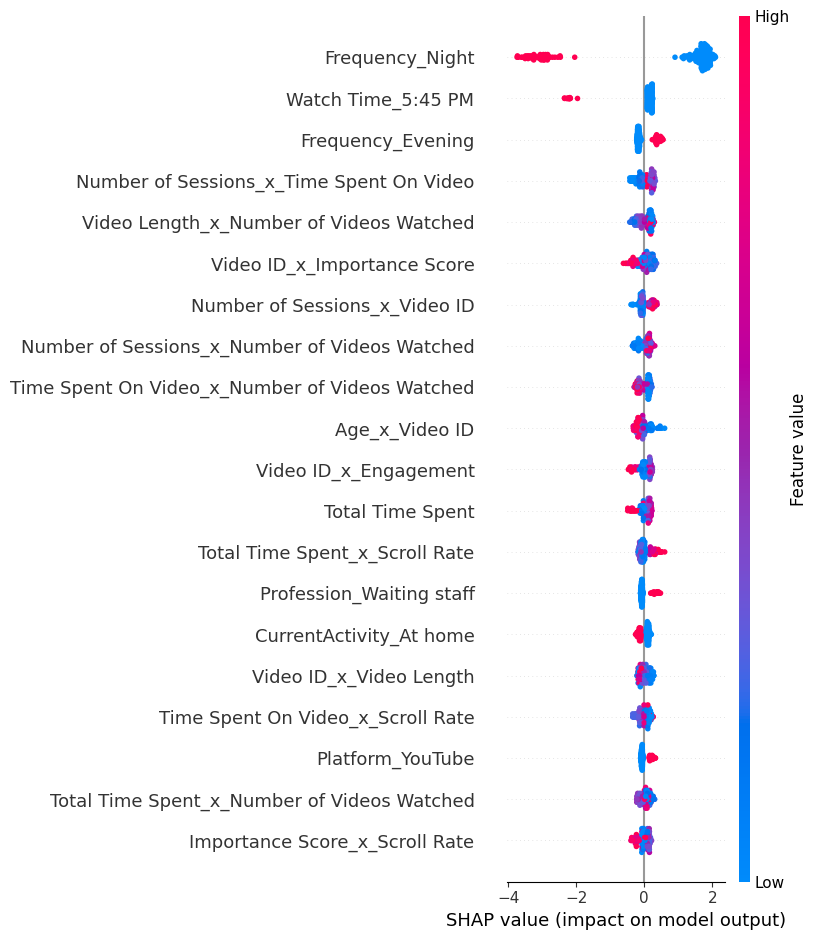

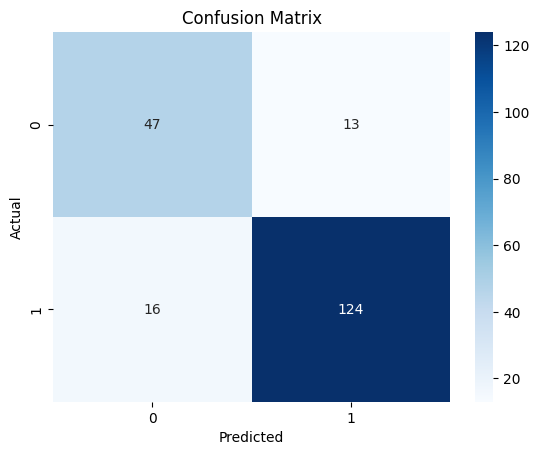

<Figure size 640x480 with 0 Axes>

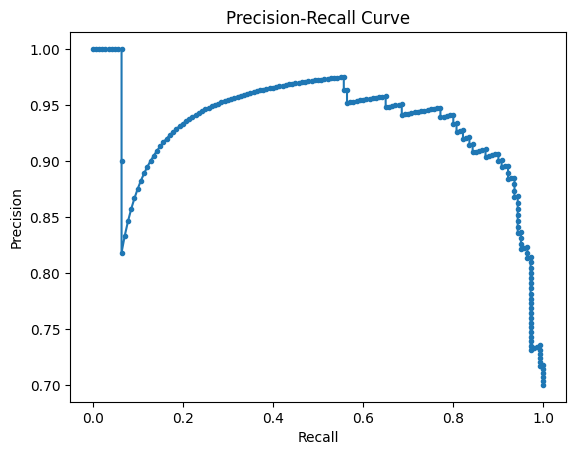

<Figure size 640x480 with 0 Axes>

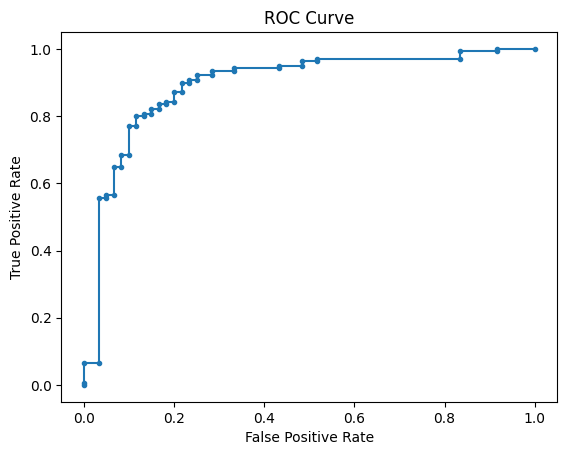

Iteration 3/10
Hyperparameters: {'n_estimators': 750, 'max_depth': 2, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.5, 'min_child_weight': 3, 'reg_alpha': 0.01, 'reg_lambda': 5.0, 'scale_pos_weight': None}


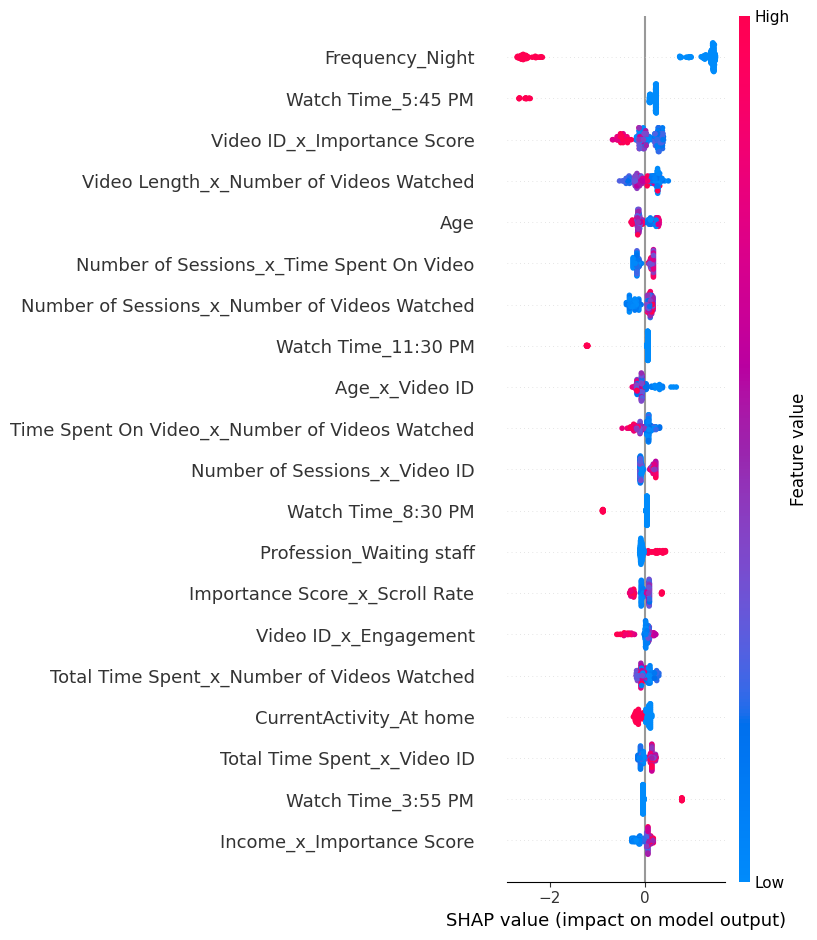

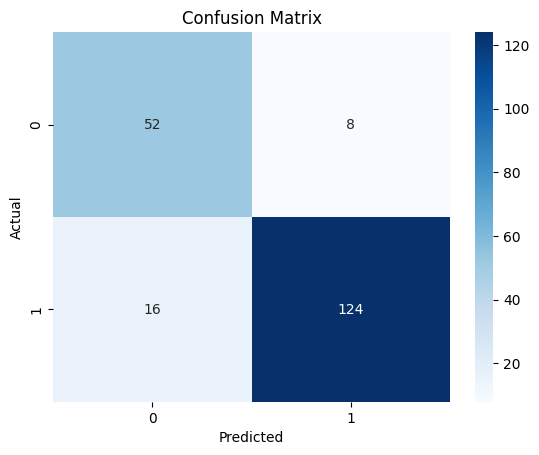

<Figure size 640x480 with 0 Axes>

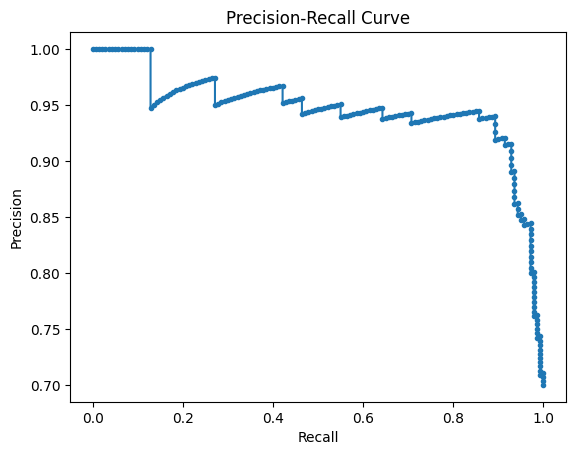

<Figure size 640x480 with 0 Axes>

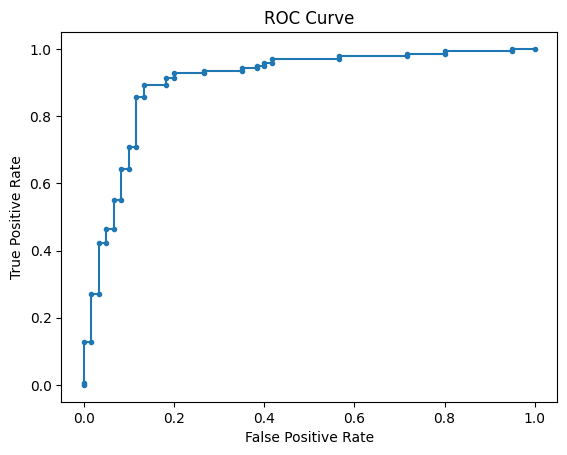

Iteration 4/10
Hyperparameters: {'n_estimators': 600, 'max_depth': 12, 'learning_rate': 0.01, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.0, 'min_child_weight': 1, 'reg_alpha': 1.0, 'reg_lambda': 5.0, 'scale_pos_weight': None}


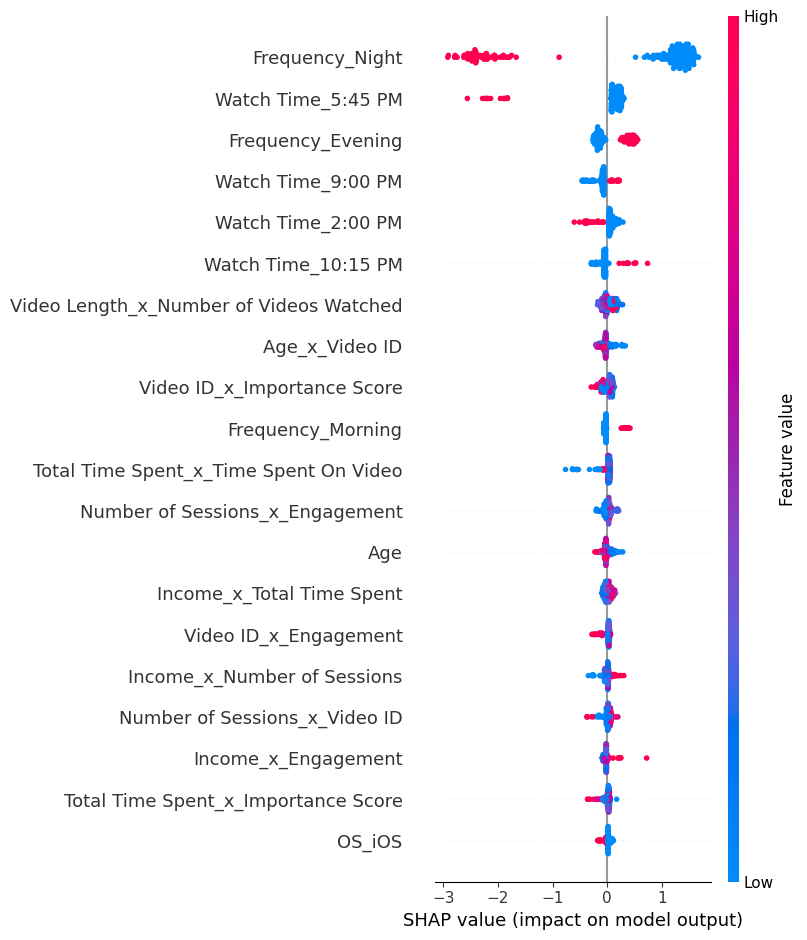

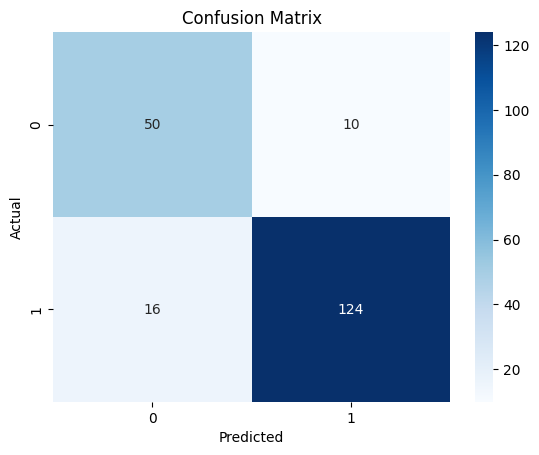

<Figure size 640x480 with 0 Axes>

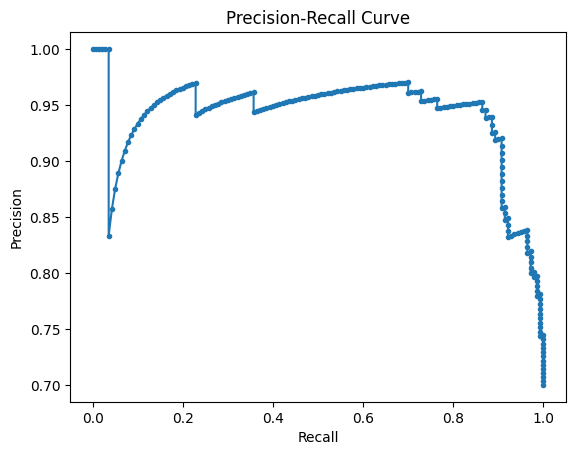

<Figure size 640x480 with 0 Axes>

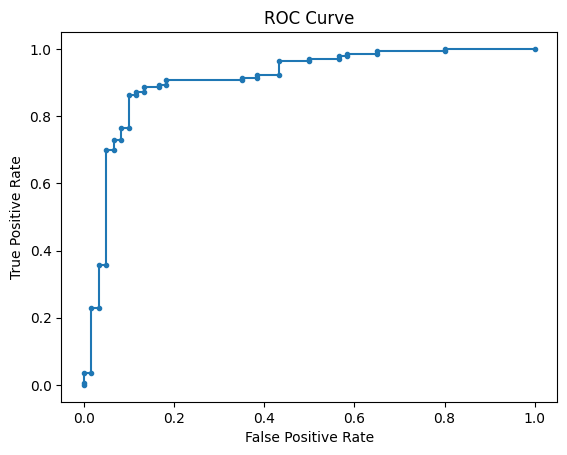

Iteration 5/10
Hyperparameters: {'n_estimators': 700, 'max_depth': 2, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.3, 'min_child_weight': 5, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'scale_pos_weight': 0.5151515151515151}


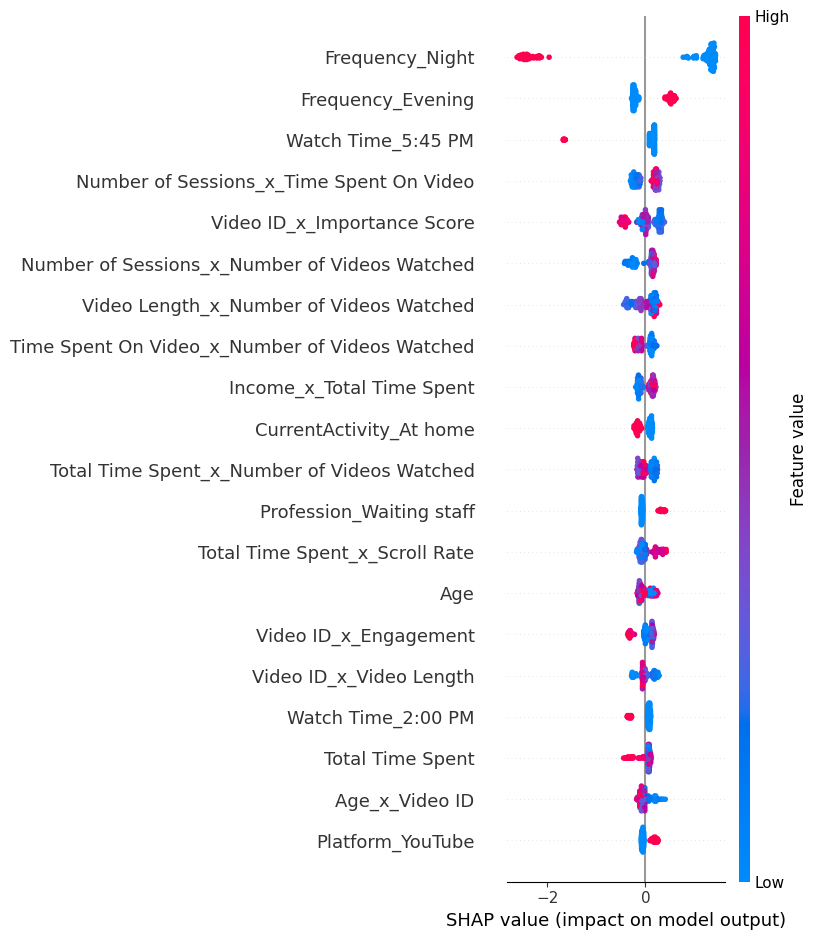

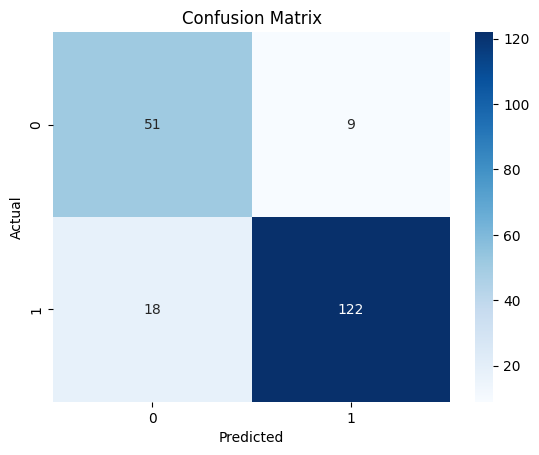

<Figure size 640x480 with 0 Axes>

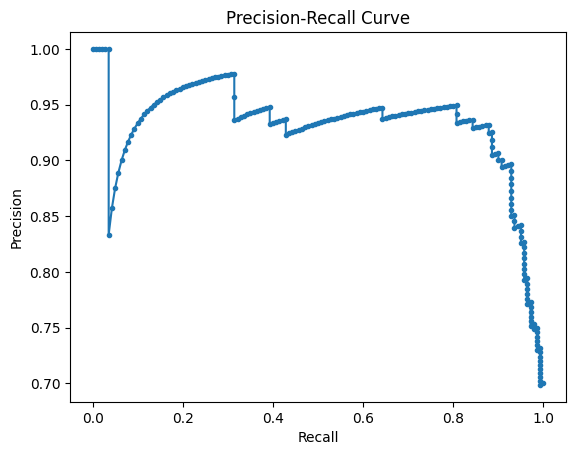

<Figure size 640x480 with 0 Axes>

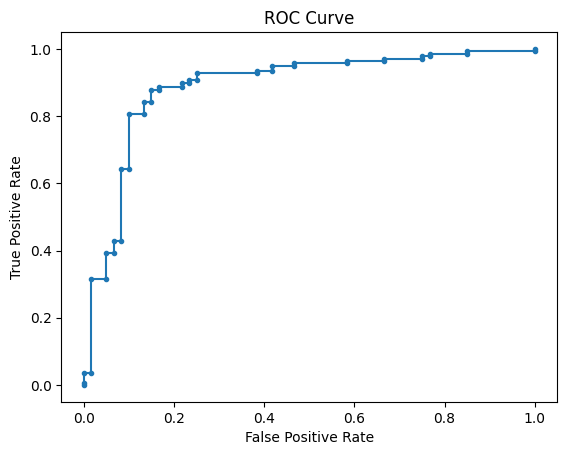

Iteration 6/10
Hyperparameters: {'n_estimators': 750, 'max_depth': 9, 'learning_rate': 0.05, 'subsample': 1.0, 'colsample_bytree': 0.8, 'gamma': 0.5, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 5.0, 'scale_pos_weight': 0.5151515151515151}


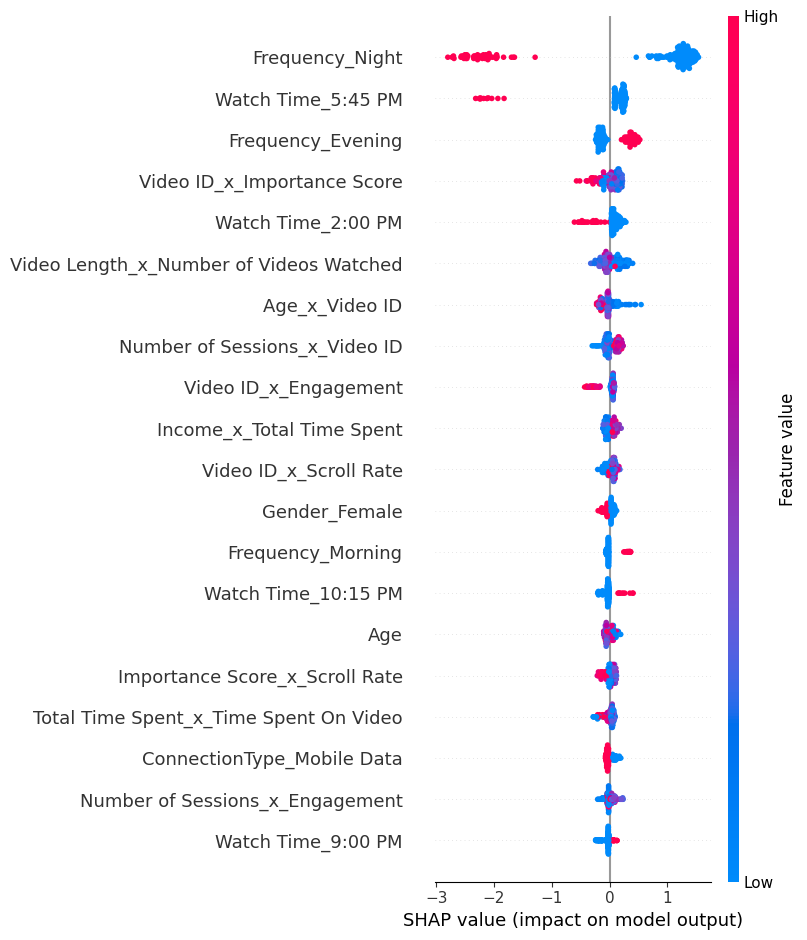

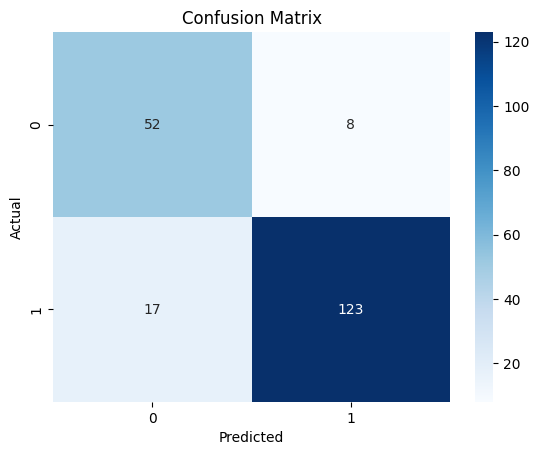

<Figure size 640x480 with 0 Axes>

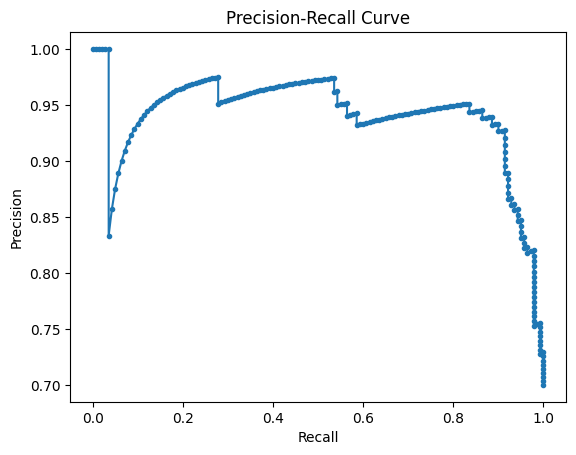

<Figure size 640x480 with 0 Axes>

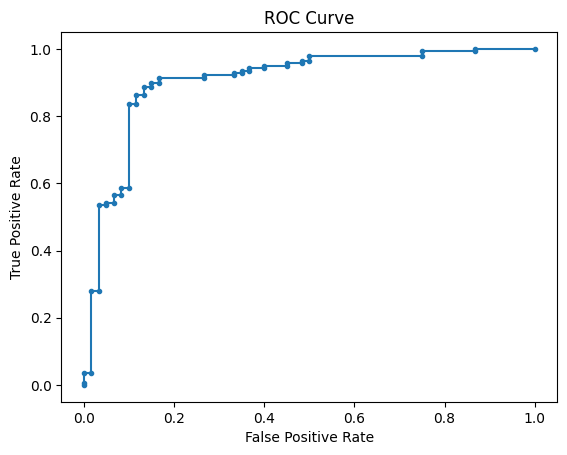

Iteration 7/10
Hyperparameters: {'n_estimators': 600, 'max_depth': 9, 'learning_rate': 0.2, 'subsample': 0.8, 'colsample_bytree': 0.6, 'gamma': 0.1, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'scale_pos_weight': None}


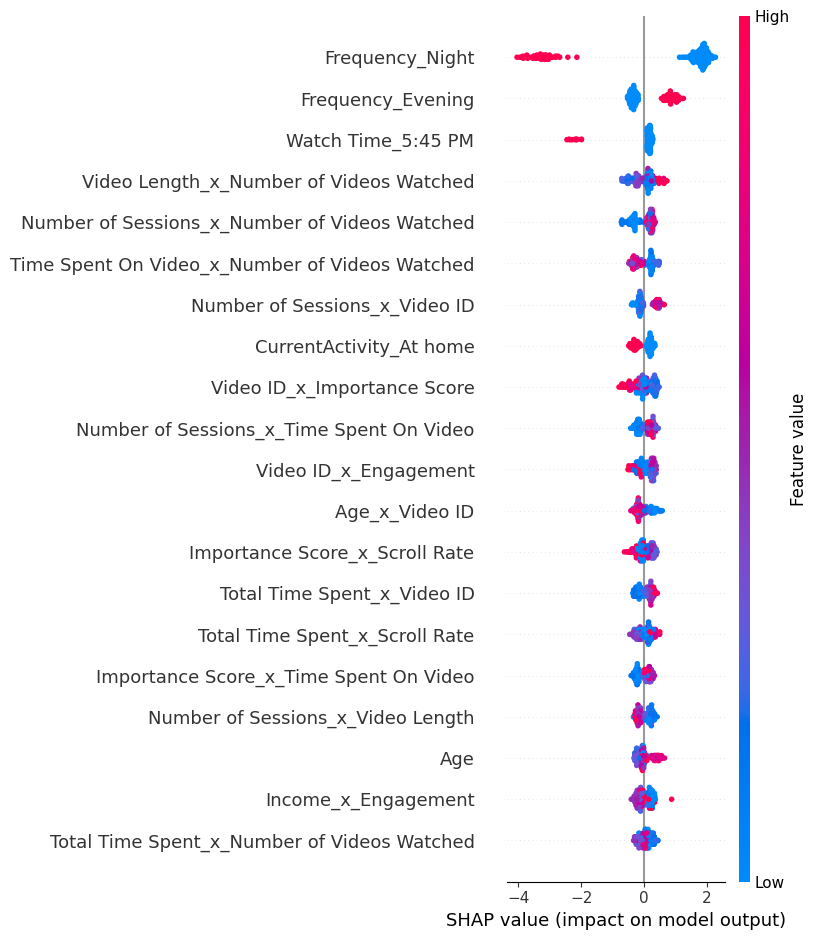

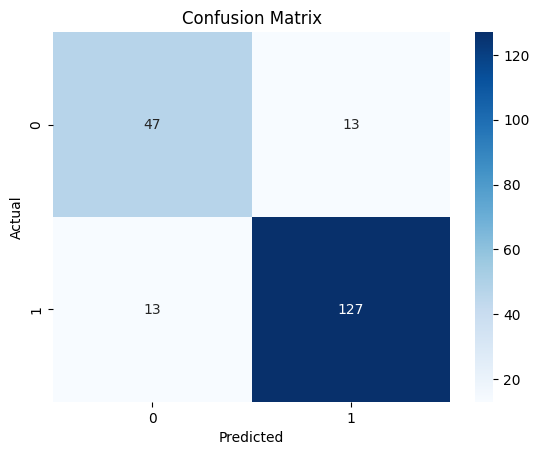

<Figure size 640x480 with 0 Axes>

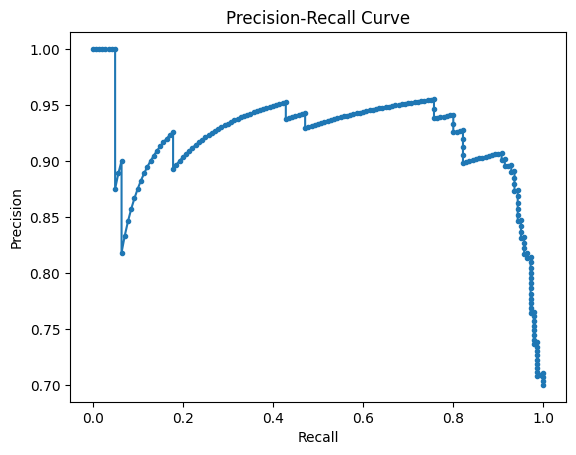

<Figure size 640x480 with 0 Axes>

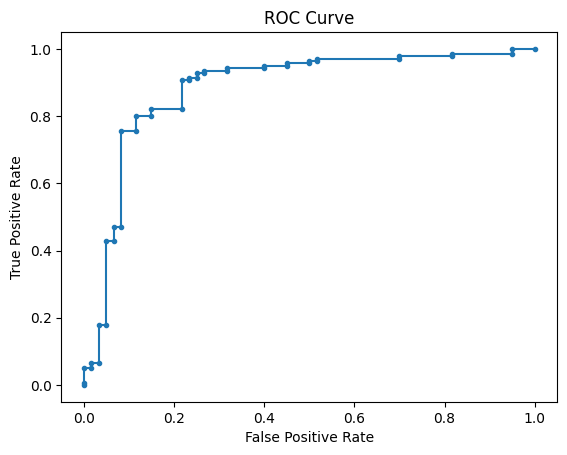

Iteration 8/10
Hyperparameters: {'n_estimators': 650, 'max_depth': 3, 'learning_rate': 0.2, 'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 3, 'reg_alpha': 0.1, 'reg_lambda': 1.5, 'scale_pos_weight': 0.5151515151515151}


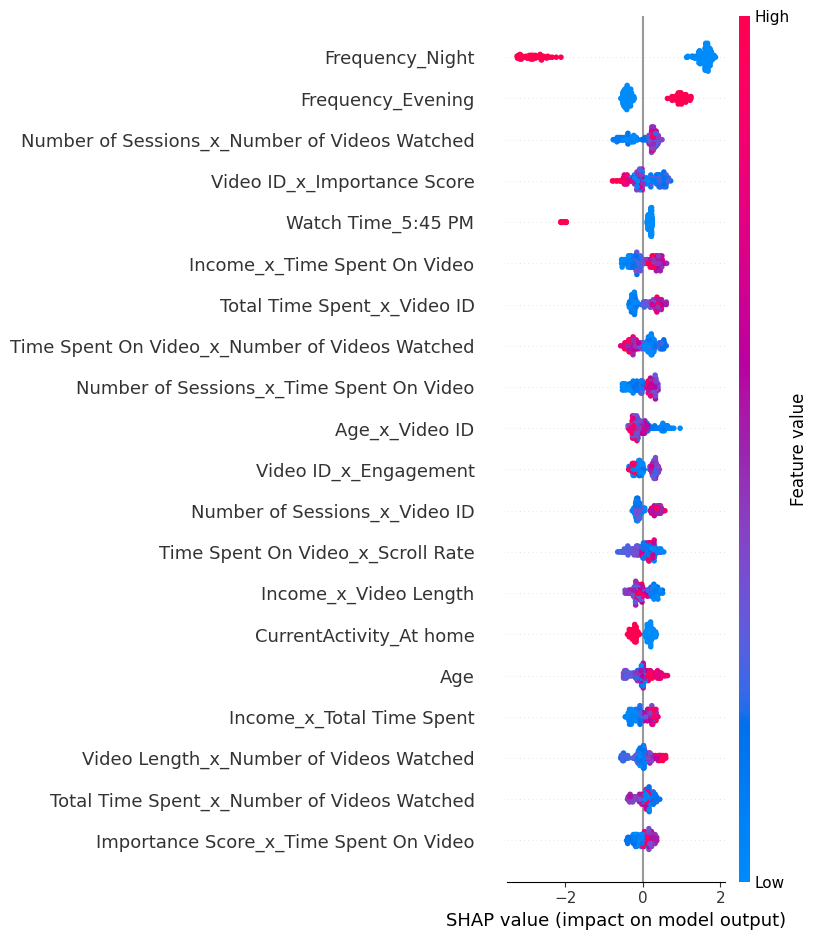

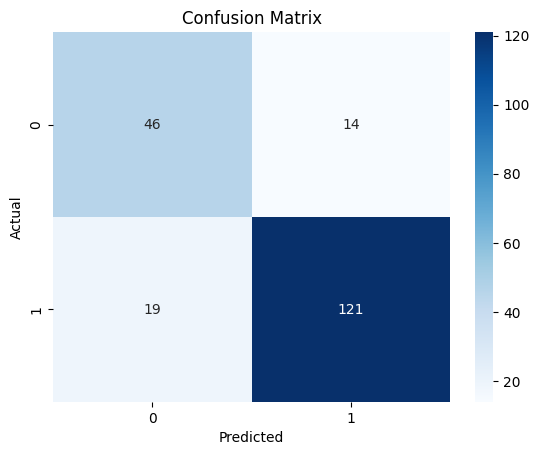

<Figure size 640x480 with 0 Axes>

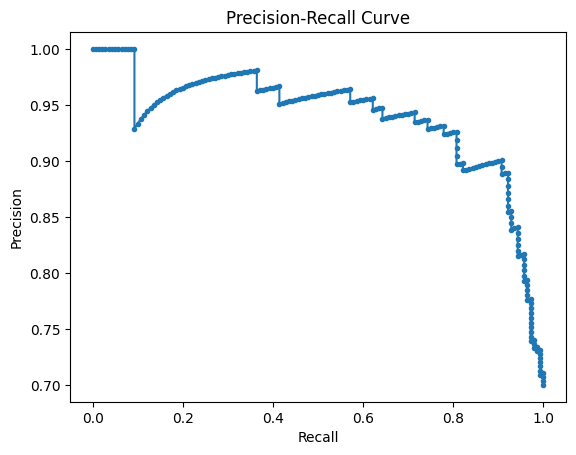

<Figure size 640x480 with 0 Axes>

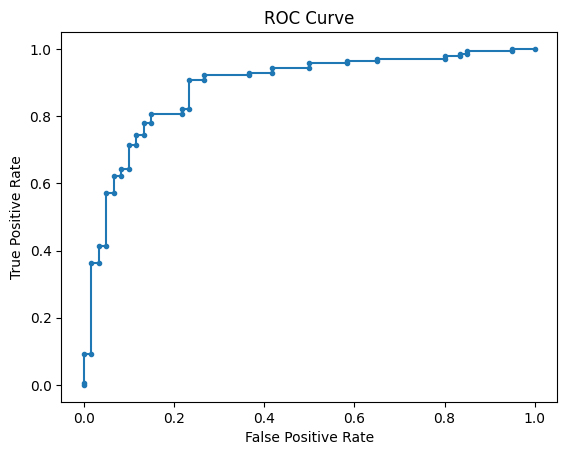

Iteration 9/10
Hyperparameters: {'n_estimators': 550, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.0, 'min_child_weight': 3, 'reg_alpha': 1.0, 'reg_lambda': 1.5, 'scale_pos_weight': None}


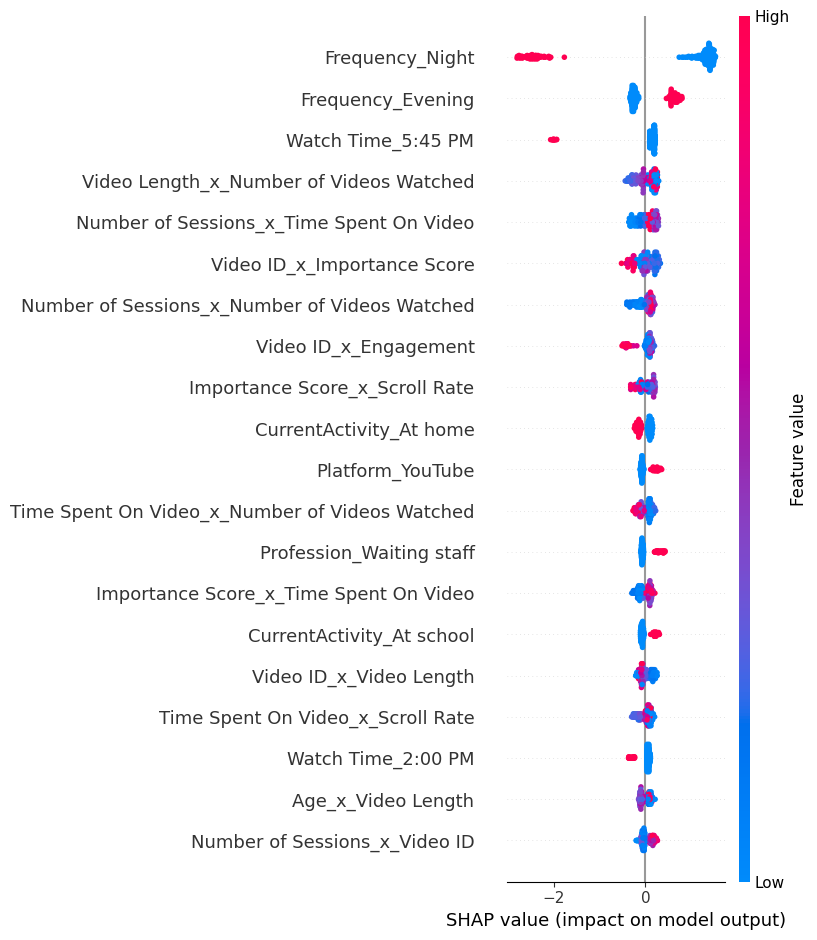

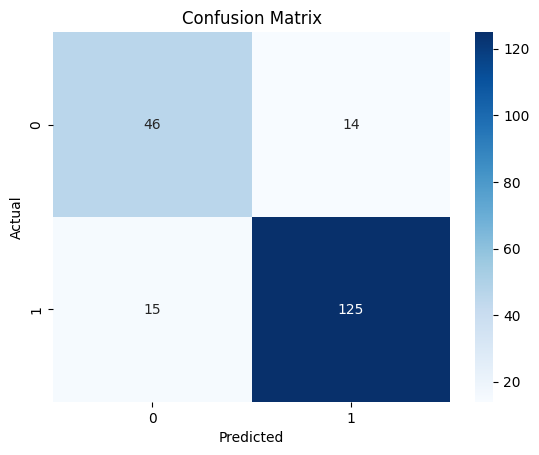

<Figure size 640x480 with 0 Axes>

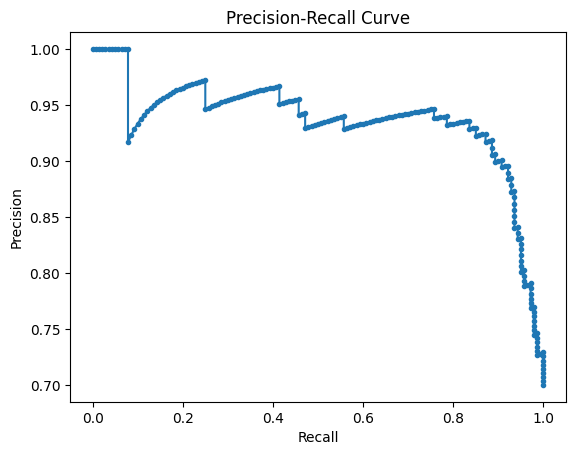

<Figure size 640x480 with 0 Axes>

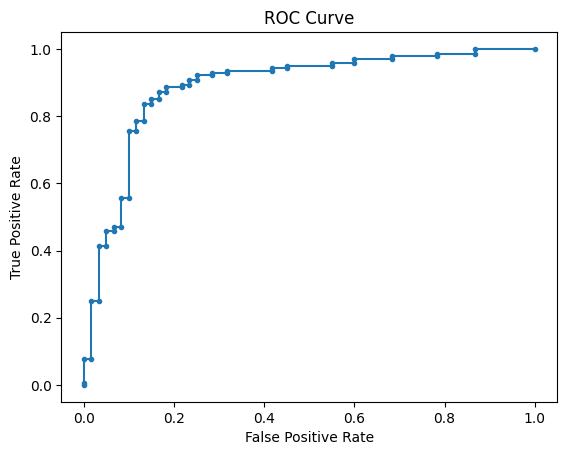

Iteration 10/10
Hyperparameters: {'n_estimators': 850, 'max_depth': 2, 'learning_rate': 0.2, 'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 0.3, 'min_child_weight': 5, 'reg_alpha': 0.0, 'reg_lambda': 5.0, 'scale_pos_weight': 0.5151515151515151}


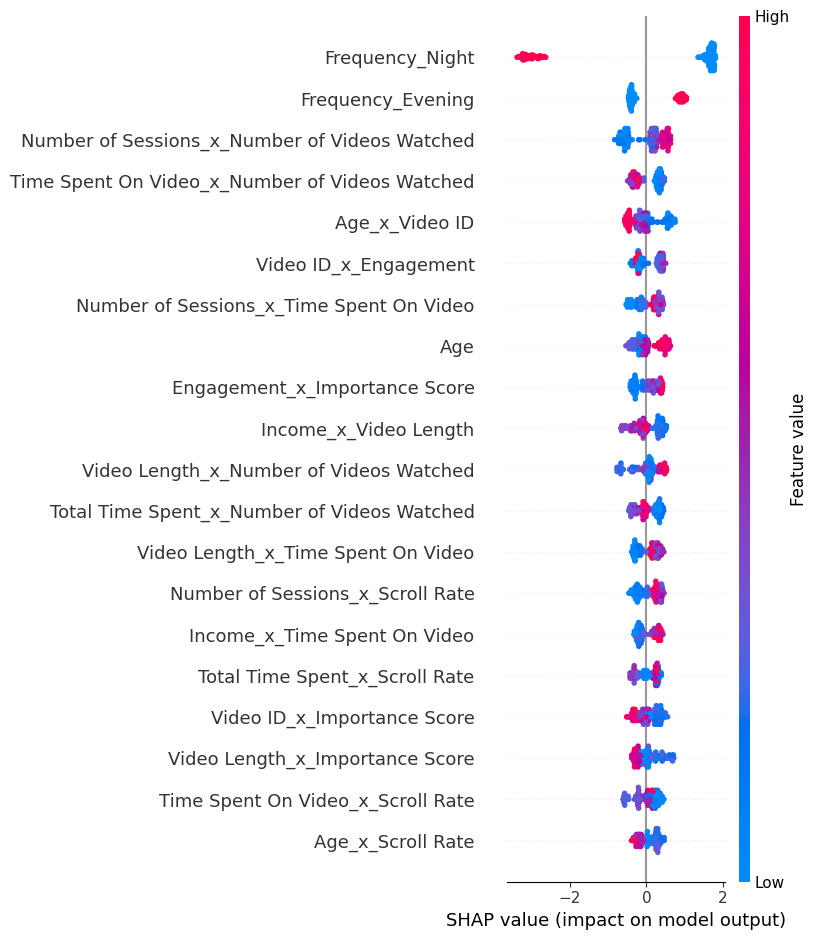

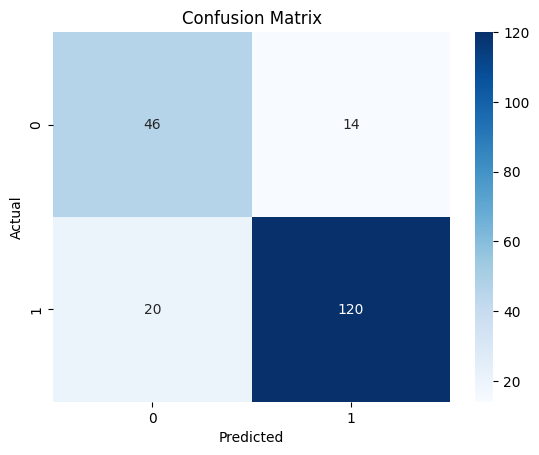

<Figure size 640x480 with 0 Axes>

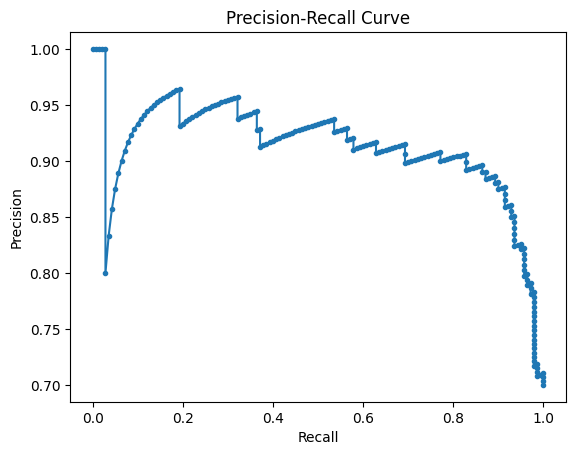

<Figure size 640x480 with 0 Axes>

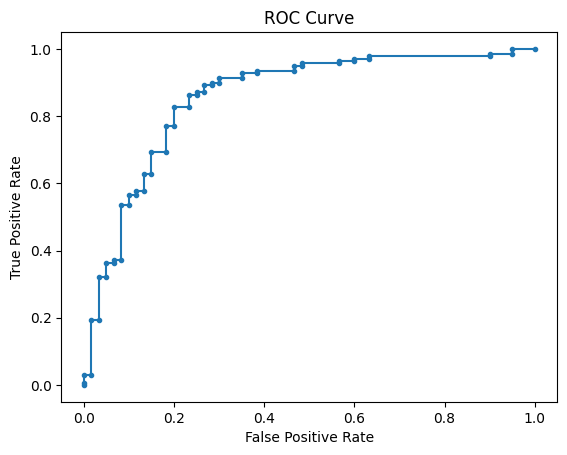

<Figure size 640x480 with 0 Axes>

In [63]:
from xgboost import XGBClassifier

neg_class_count = (y_train == 0).sum()  # Count of negative samples
pos_class_count = (y_train == 1).sum()  # Count of positive samples
scale_pos_weight = float(neg_class_count / pos_class_count)

param_grid = {
    'n_estimators': list(range(50, 1000, 50)),  # Number of trees
    'max_depth': [2, 3, 5, 7, 9, 12],  # Maximum depth of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate
    'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns for each tree
    'gamma': [0, 0.1, 0.3, 0.5],  # Minimum loss reduction for further tree split
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight (hessian) needed in a child
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2, 5],  # L2 regularization term on weights
    'scale_pos_weight': [scale_pos_weight, None]  # Dynamically computed weight
}

xgb_model = XGBClassifier(random_state=0)

num_iterations = 10
for i in range(num_iterations):
    # Randomly sample hyperparameters
    hyperparams = {k: np.random.choice(v) for k, v in param_grid.items()}
    print(f"Iteration {i+1}/{num_iterations}")
    print("Hyperparameters:", hyperparams)
    run_experiment(features=features, target=target, model=xgb_model, hyperparams=hyperparams)


In [132]:
rf_model = RandomForestClassifier(random_state=0)

param_grid = {
    'n_estimators': list(range(50, 1000, 50)),  # Number of trees
    'max_depth': [2, 3, 5, 7, 9, 12],  # Maximum depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}

num_iterations = 50
for i in range(num_iterations):
    # Randomly sample hyperparameters
    hyperparams = {k: np.random.choice(v) for k, v in param_grid.items()}
    print(f"Iteration {i+1}/{num_iterations}")
    print("Hyperparameters:", hyperparams)
    run_experiment(features=features, target=target, model=rf_model, hyperparams=hyperparams)


Iteration 1/50
Hyperparameters: {'n_estimators': 600, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Iteration 2/50
Hyperparameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None}
Iteration 3/50
Hyperparameters: {'n_estimators': 950, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt'}
Iteration 4/50
Hyperparameters: {'n_estimators': 350, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None}
Iteration 5/50
Hyperparameters: {'n_estimators': 800, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}
Iteration 6/50
Hyperparameters: {'n_estimators': 550, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}
Iteration 7/50
Hyperparameters: {'n_estimators': 800, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2'}
Iteration 8/50


In [133]:
mlp_model = MLPClassifier(random_state=0)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 300, 400]
}

import random  # Import Python's random module

num_iterations = 50
for i in range(num_iterations):
    # Randomly sample hyperparameters using random.choice()
    hyperparams = {k: random.choice(v) for k, v in param_grid.items()}
    print(f"Iteration {i+1}/{num_iterations}")
    print("Hyperparameters:", hyperparams)
    run_experiment(features=features, target=target, model=mlp_model, hyperparams=hyperparams)

Iteration 1/50
Hyperparameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'max_iter': 400}
Iteration 2/50
Hyperparameters: {'hidden_layer_sizes': (100, 100), 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate': 'constant', 'max_iter': 300}
Iteration 3/50
Hyperparameters: {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.001, 'learning_rate': 'adaptive', 'max_iter': 300}
Iteration 4/50
Hyperparameters: {'hidden_layer_sizes': (100, 50), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.01, 'learning_rate': 'adaptive', 'max_iter': 300}
Iteration 5/50
Hyperparameters: {'hidden_layer_sizes': (50,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'max_iter': 400}
Iteration 6/50
Hyperparameters: {'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0001, 'learning_rate': 'constant', 'max_iter': 400}
Iter